In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
# create empty datset with column year and question_category
df = pd.DataFrame(columns=['year', 'question_category'])

# questions 

dic = {'year': [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,2023],
         'question_category': ['POM','MI','POM','MDTM','MDTM','MDTM','FNL','FNL','MI','RDUH','MI','FNL','SHM','MDTM','SHM','RDUH','FNL','MI','MDTM','MDTM','MI','SHM','MDTM','TG','RDUH','POM','FNL','SHM','FNL','SHM']}


df = pd.DataFrame(dic)

In [3]:
# Encode question categories
le = LabelEncoder()
df['question_category_encoded'] = le.fit_transform(df['question_category'])

In [4]:
df

,year,question_category,question_category_encoded
0,1994,POM,3
1,1995,MI,2
2,1996,POM,3
3,1997,MDTM,1
4,1998,MDTM,1
5,1999,MDTM,1
6,2000,FNL,0
7,2001,FNL,0
8,2002,MI,2
9,2003,RDUH,4


In [5]:
# filter the df up to 2019
df = df[df['year'] < 2022]


In [6]:
df

,year,question_category,question_category_encoded
0,1994,POM,3
1,1995,MI,2
2,1996,POM,3
3,1997,MDTM,1
4,1998,MDTM,1
5,1999,MDTM,1
6,2000,FNL,0
7,2001,FNL,0
8,2002,MI,2
9,2003,RDUH,4


In [7]:
# Create sequences
sequence_length = 5  # Length of the input sequence
data = []
labels = []
for i in range(len(df) - sequence_length):
    seq = df['question_category_encoded'].values[i:i+sequence_length]
    label = df['question_category_encoded'].values[i+sequence_length]
    data.append(seq)
    labels.append(label)

In [8]:
len(data)

23

In [9]:
len(labels)

23

In [10]:
# Convert to PyTorch tensors
data = torch.tensor(data)
labels = torch.tensor(labels)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_7533/3865685093.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  data = torch.tensor(data)


In [11]:
class QuestionCategoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(QuestionCategoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # LSTM output
        
        # Decode the last output
        out = self.fc(out[:, -1, :])
        return out

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Attention layer
        self.attention = nn.Linear(hidden_size, 1)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        
        # Attention weights
        attn_weights = torch.tanh(self.attention(out))  # Shape: (batch_size, seq_length, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Normalize over the time dimension
        
        # Weighted sum of LSTM outputs based on attention weights
        context_vector = torch.sum(attn_weights * out, dim=1)  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer
        output = self.fc(context_vector)  # Shape: (batch_size, output_size)
        
        return output

# Model hyperparameters
input_size = 1  # Each category is represented by a single number
hidden_size = 64  # Number of LSTM units
output_size = len(le.classes_)  # Number of categories to predict
num_layers = 1

In [13]:
# Prepare DataLoader
class QuestionCategoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.unsqueeze(-1).float()  # Add a feature dimension
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
# Hyperparameters
input_size = 1  # Each category is encoded as a single integer
hidden_size = 64
output_size = len(le.classes_)  # Number of unique categories
num_layers = 1
num_epochs = 300
batch_size = 4
learning_rate = 0.001

In [15]:
dataset = QuestionCategoryDataset(data, labels)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
# Initialize model, loss function, and optimizer
# model = QuestionCategoryLSTM(input_size, hidden_size, output_size, num_layers)
model = LSTMWithAttention(input_size, hidden_size, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Initialize list to store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0  # Accumulate loss over an epoch
    for sequences, targets in train_loader:
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [10/300], Loss: 1.8494
Epoch [20/300], Loss: 1.7853
Epoch [30/300], Loss: 1.7601
Epoch [40/300], Loss: 1.7107
Epoch [50/300], Loss: 1.5929
Epoch [60/300], Loss: 1.5444
Epoch [70/300], Loss: 1.5120
Epoch [80/300], Loss: 1.4627
Epoch [90/300], Loss: 1.3645
Epoch [100/300], Loss: 1.3020
Epoch [110/300], Loss: 1.3319
Epoch [120/300], Loss: 1.2534
Epoch [130/300], Loss: 1.1966
Epoch [140/300], Loss: 1.1179
Epoch [150/300], Loss: 1.1771
Epoch [160/300], Loss: 1.0223
Epoch [170/300], Loss: 0.9536
Epoch [180/300], Loss: 0.9060
Epoch [190/300], Loss: 0.8226
Epoch [200/300], Loss: 0.7696
Epoch [210/300], Loss: 0.7278
Epoch [220/300], Loss: 0.6701
Epoch [230/300], Loss: 0.6162
Epoch [240/300], Loss: 0.5575
Epoch [250/300], Loss: 0.5282
Epoch [260/300], Loss: 0.4794
Epoch [270/300], Loss: 0.4577
Epoch [280/300], Loss: 0.4215
Epoch [290/300], Loss: 0.3748
Epoch [300/300], Loss: 0.3377


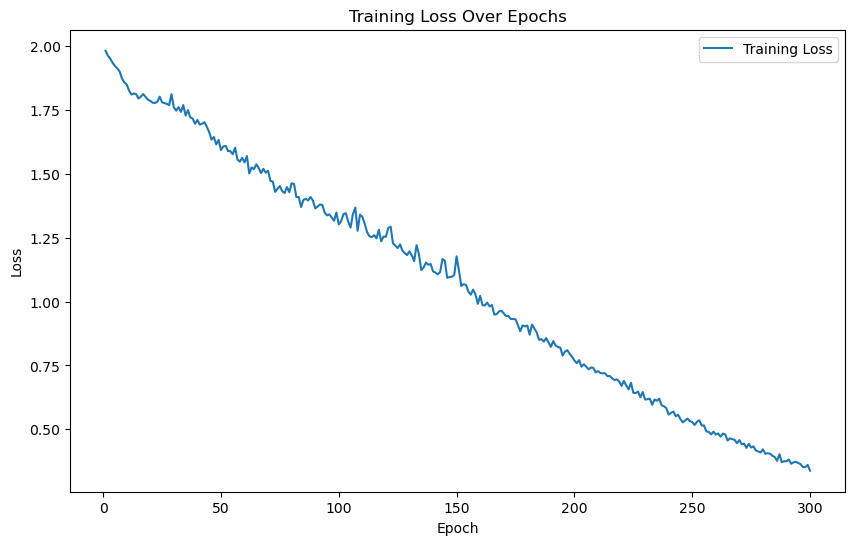

In [18]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [19]:
import numpy as np

# Define the sequence length used during training, e.g., 5
# sequence_length = 10

# Prepare the latest sequence from the data
# Use the last 5 question categories as the input sequence
latest_sequence = df['question_category'].iloc[-sequence_length:].values
latest_sequence = le.transform(latest_sequence)  # Encode categories
latest_sequence = torch.tensor(latest_sequence, dtype=torch.long).unsqueeze(0).unsqueeze(-1)  # Shape: (1, sequence_length, 1)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Predict next category
    output = model(latest_sequence.float())
    probabilities = nn.functional.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    predicted_category_index = np.argmax(probabilities)
    predicted_category = le.inverse_transform([predicted_category_index])[0]

# Display the results
probabilities_dict = dict(zip(le.classes_, probabilities))
print("Probabilities for each category:", probabilities_dict)
print("Predicted category for the next year:", predicted_category)

Probabilities for each category: {'FNL': 0.0023404346, 'MDTM': 0.8618161, 'MI': 0.019480921, 'POM': 0.0020421317, 'RDUH': 3.2762484e-05, 'SHM': 0.1142726, 'TG': 1.5099694e-05}
Predicted category for the next year: MDTM


In [20]:
latest_sequence = df['question_category'].iloc[-sequence_length:].values


In [21]:
latest_sequence

array(['TG', 'RDUH', 'POM', 'FNL', 'SHM'], dtype=object)